![dvd_image](dvd_image.jpg)

A DVD rental company needs your help! They want to figure out how many days a customer will rent a DVD for based on some features and has approached you for help. They want you to try out some regression models which will help predict the number of days a customer will rent a DVD for. The company wants a model which yeilds a MSE of 3 or less on a test set. The model you make will help the company become more efficient inventory planning.

The data they provided is in the csv file `rental_info.csv`. It has the following features:
- `"rental_date"`: The date (and time) the customer rents the DVD.
- `"return_date"`: The date (and time) the customer returns the DVD.
- `"amount"`: The amount paid by the customer for renting the DVD.
- `"amount_2"`: The square of `"amount"`.
- `"rental_rate"`: The rate at which the DVD is rented for.
- `"rental_rate_2"`: The square of `"rental_rate"`.
- `"release_year"`: The year the movie being rented was released.
- `"length"`: Lenght of the movie being rented, in minuites.
- `"length_2"`: The square of `"length"`.
- `"replacement_cost"`: The amount it will cost the company to replace the DVD.
- `"special_features"`: Any special features, for example trailers/deleted scenes that the DVD also has.
- `"NC-17"`, `"PG"`, `"PG-13"`, `"R"`: These columns are dummy variables of the rating of the movie. It takes the value 1 if the move is rated as the column name and 0 otherwise. For your convinience, the reference dummy has already been dropped.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Import any additional modules and start coding below

In [74]:
rental_info=pd.read_csv('rental_info.csv')

In [75]:
rental_info.head()

,rental_date,return_date,amount,release_year,rental_rate,length,replacement_cost,special_features,NC-17,PG,PG-13,R,amount_2,length_2,rental_rate_2
0,2005-05-25 02:54:33+00:00,2005-05-28 23:40:33+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
1,2005-06-15 23:19:16+00:00,2005-06-18 19:24:16+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
2,2005-07-10 04:27:45+00:00,2005-07-17 10:11:45+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
3,2005-07-31 12:06:41+00:00,2005-08-02 14:30:41+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401
4,2005-08-19 12:30:04+00:00,2005-08-23 13:35:04+00:00,2.99,2005.0,2.99,126.0,16.99,"{Trailers,""Behind the Scenes""}",0,0,0,1,8.9401,15876.0,8.9401


In [76]:
rental_info['rental_date']=pd.to_datetime(rental_info['rental_date'])
rental_info['return_date']=pd.to_datetime(rental_info['return_date'])
rental_info['rental_length_days']=(rental_info['return_date']-rental_info['rental_date']).dt.days.astype('float')

In [77]:
rental_info['special_features'].unique()

array(['{Trailers,"Behind the Scenes"}', '{Trailers}',
       '{Commentaries,"Behind the Scenes"}', '{Trailers,Commentaries}',
       '{"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes","Behind the Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes"}',
       '{"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes","Behind the Scenes"}',
       '{Commentaries,"Deleted Scenes"}', '{Commentaries}',
       '{Trailers,Commentaries,"Behind the Scenes"}',
       '{Trailers,"Deleted Scenes"}', '{"Deleted Scenes"}',
       '{Trailers,Commentaries,"Deleted Scenes","Behind the Scenes"}'],
      dtype=object)

In [78]:
rental_info['deleted_scenes'] = np.where(rental_info['special_features'].str.contains('Deleted Scenes'),1,0)
rental_info['behind_the_scenes'] = np.where(rental_info['special_features'].str.contains('Behind the Scenes'),1,0)

In [79]:
X = rental_info[['amount','release_year','rental_rate','length','replacement_cost','NC-17','PG','PG-13','R','deleted_scenes','behind_the_scenes','amount_2','length_2','rental_rate_2']]
y = rental_info['rental_length_days']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=9)

In [80]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15861 entries, 0 to 15860
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   amount             15861 non-null  float64
 1   release_year       15861 non-null  float64
 2   rental_rate        15861 non-null  float64
 3   length             15861 non-null  float64
 4   replacement_cost   15861 non-null  float64
 5   NC-17              15861 non-null  int64  
 6   PG                 15861 non-null  int64  
 7   PG-13              15861 non-null  int64  
 8   R                  15861 non-null  int64  
 9   deleted_scenes     15861 non-null  int64  
 10  behind_the_scenes  15861 non-null  int64  
 11  amount_2           15861 non-null  float64
 12  length_2           15861 non-null  float64
 13  rental_rate_2      15861 non-null  float64
dtypes: float64(8), int64(6)
memory usage: 1.7 MB


In [81]:
lasso=Lasso(alpha = 0.1, random_state=9)
Lasso_coef = lasso.fit(X,y).coef_

<function matplotlib.pyplot.show(close=None, block=None)>

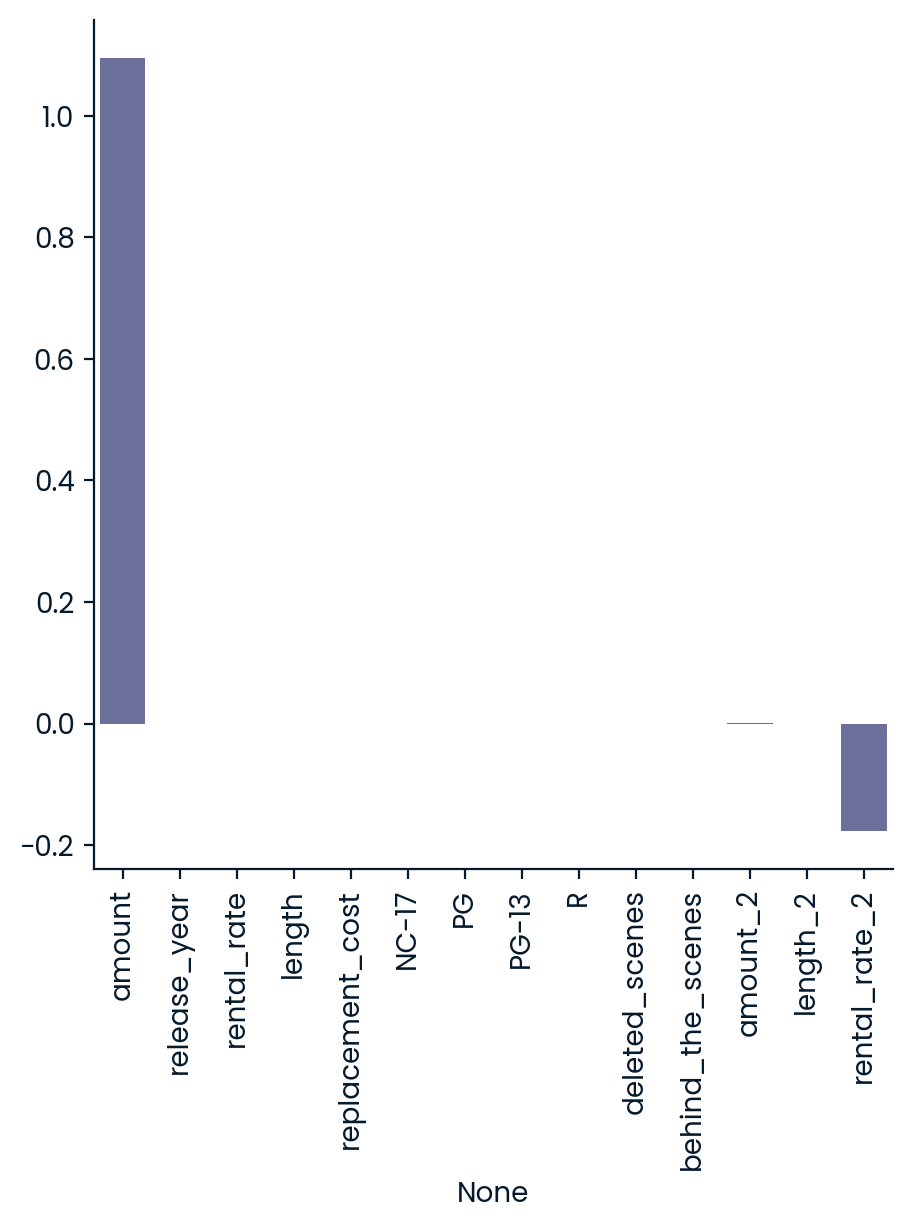

In [82]:
sns.catplot(x=X.columns,y=Lasso_coef,kind='bar')
plt.xticks(rotation=90)
plt.show

In [83]:
#For linear regression
kf = KFold(n_splits=5,shuffle=True,random_state=9)
params = {'fit_intercept':[True,False],
          'positive':[True,False]}
linreg = LinearRegression()
linreg_cv = RandomizedSearchCV(linreg,params,cv=kf,random_state = 9)
linreg_cv.fit(X_train,y_train)
print(linreg_cv.best_params_,linreg_cv.best_score_)

{'positive': False, 'fit_intercept': True} 0.5870282389273414


In [84]:
#For DecisionTree regression
kf = KFold(n_splits=5,shuffle=True,random_state=9)
params = {'max_depth' : [None,2,5,8,10,12,15,18,20],
          'min_samples_split' : [2,3,5,8,10],
          'min_samples_leaf' : [1,5,10]}
decreg = DecisionTreeRegressor()
decreg_cv = RandomizedSearchCV(decreg,params,cv=kf,random_state = 9)
decreg_cv.fit(X_train,y_train)
print(decreg_cv.best_params_,decreg_cv.best_score_)

{'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': None} 0.6672498007012095


In [85]:
#For RandomForest regression
kf = KFold(n_splits=5,shuffle=True,random_state=9)
params = {'n_estimators': [10,20,50, 100, 200],
            'max_depth': [None,2,5, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [0.1,0.2,1, 2, 4,5]}
ranreg = RandomForestRegressor()
ranreg_cv = RandomizedSearchCV(ranreg,params,cv=kf,random_state = 9)
ranreg_cv.fit(X_train,y_train)
print(ranreg_cv.best_params_,ranreg_cv.best_score_)

{'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20} 0.6917714437456313


In [86]:
#For linear regression
linreg = LinearRegression()
linreg.fit(X_train,y_train)
y_pred = linreg.predict(X_test)
mse_linear = mean_squared_error(y_test,y_pred)
print(mse_linear)

2.941723864697602


In [87]:
#For RandomForest regression
ranreg = RandomForestRegressor(n_estimators=100,min_samples_leaf=2,max_depth=20,random_state=9)
ranreg.fit(X_train,y_train)
y_pred = ranreg.predict(X_test)
mse_forest = mean_squared_error(y_test,y_pred)
print(mse_forest)

2.0492608252470967


In [88]:
best_model=ranreg #RandomForestRegressor
best_mse = mse_forest